In [ ]:
# ============================================
# RICE DISEASE DETECTION USING RESNET-18
# Diseases: Brown Spot, Bacterial Leaf Blight, Leaf Scald
# ============================================

# Cell 1: Setup and Install Required Packages
# ============================================
!pip install -q kaggle
!pip install -q torchsummary

In [ ]:
# Cell 2: Import Libraries
# ============================================
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


In [ ]:
# Cell 3: Setup Kaggle API and Download Dataset
# ============================================
# Upload your kaggle.json file when prompted
from google.colab import files

print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle.json

# Download the dataset
!kaggle datasets download -d anshulm257/rice-disease-dataset
!unzip -q rice-disease-dataset.zip
!rm rice-disease-dataset.zip

print("Dataset downloaded and extracted successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/anshulm257/rice-disease-dataset
License(s): unknown
 98% 991M/0.99G [00:07<00:00, 121MB/s]
100% 0.99G/0.99G [00:11<00:00, 94.4MB/s]
Dataset downloaded and extracted successfully!


In [ ]:
# Cell 4: Explore Dataset Structure
# ============================================
import os

# Define the correct path
data_dir = '/content/Rice_Leaf_AUG'

print(f"Dataset location: {data_dir}")
print("="*50)

# List all folders in the dataset
print("\nAvailable disease folders:")
folders = []
for item in sorted(os.listdir(data_dir)):
    item_path = os.path.join(data_dir, item)
    if os.path.isdir(item_path):
        # Count images
        image_files = [f for f in os.listdir(item_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if image_files:
            folders.append(item)
            print(f"  • {item}: {len(image_files)} images")

# Store for use in other cells
target_diseases = folders[:3]  # Take first 3 for this model
print(f"\nWill use these 3 diseases for the model: {target_diseases}")

Dataset location: /content/Rice_Leaf_AUG

Available disease folders:
  • Bacterial Leaf Blight: 636 images
  • Brown Spot: 646 images
  • Healthy Rice Leaf: 653 images
  • Leaf Blast: 634 images
  • Leaf scald: 628 images
  • Sheath Blight: 632 images

Will use these 3 diseases for the model: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf']


In [ ]:
# Cell 5: Create Custom Dataset Class
# ============================================
from sklearn.model_selection import train_test_split
import numpy as np

class RiceDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Custom dataset for Rice Disease Detection
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

        # Verify all image paths exist
        valid_paths = []
        valid_labels = []
        for path, label in zip(image_paths, labels):
            if os.path.exists(path):
                valid_paths.append(path)
                valid_labels.append(label)
            else:
                print(f"Warning: Image not found - {path}")

        self.image_paths = valid_paths
        self.labels = valid_labels
        print(f"Dataset created with {len(self.image_paths)} valid images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if there's an error
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def prepare_data(data_dir, target_diseases, test_size=0.2, val_size=0.2, random_state=42):
    """
    Load all images and split into train/val/test sets
    """
    all_images = []
    all_labels = []
    class_to_idx = {disease: idx for idx, disease in enumerate(target_diseases)}
    idx_to_class = {idx: disease for disease, idx in class_to_idx.items()}

    print("Loading images from folders:")
    # Load all images and labels
    for disease in target_diseases:
        disease_path = os.path.join(data_dir, disease)
        if os.path.exists(disease_path):
            # Get all image files
            image_files = [f for f in os.listdir(disease_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            # Create full paths
            image_paths = [os.path.join(disease_path, img) for img in image_files]

            print(f"  {disease}: Found {len(image_paths)} images")

            all_images.extend(image_paths)
            all_labels.extend([class_to_idx[disease]] * len(image_paths))
        else:
            print(f"  WARNING: Folder not found - {disease_path}")

    if len(all_images) == 0:
        raise ValueError("No images found! Please check the folder names and paths.")

    print(f"\nTotal images loaded: {len(all_images)}")

    # Convert to numpy arrays for sklearn
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_images, all_labels, test_size=test_size, random_state=random_state, stratify=all_labels
    )

    # Second split: separate train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state, stratify=y_temp
    )

    print(f"\nDataset splits:")
    print(f"  Train images: {len(X_train)}")
    print(f"  Validation images: {len(X_val)}")
    print(f"  Test images: {len(X_test)}")

    # Verify a few sample paths
    print(f"\nSample image paths:")
    for i in range(min(3, len(X_train))):
        print(f"  {X_train[i]}")

    return X_train.tolist(), X_val.tolist(), X_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist(), class_to_idx, idx_to_class

In [ ]:
# Cell 6: Define Data Transformations
# ============================================
# Calculate mean and std for normalization (ImageNet values work well for transfer learning)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation/Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
# Cell 7: Create Data Loaders
# ============================================

# Set the correct data directory
data_dir = '/content/Rice_Leaf_AUG'

print(f"Using data directory: {data_dir}")
print("Searching for disease folders...")

# Check what folders are in the Rice_Leaf_AUG directory
available_folders = []
for item in os.listdir(data_dir):
    item_path = os.path.join(data_dir, item)
    if os.path.isdir(item_path):
        # Count images in this folder
        images = [f for f in os.listdir(item_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if images:
            available_folders.append(item)
            print(f"  ✓ Found: '{item}' with {len(images)} images")

print(f"\nTotal folders found: {len(available_folders)}")

# Select the three target diseases
# Based on the original requirement: Brown Spot, Bacterial Leaf Blight, Leaf Scald
# Try different naming conventions
possible_names = [
    ['Brown Spot', 'Bacterial Leaf Blight', 'Leaf scald'],
    ['BrownSpot', 'BacterialLeafBlight', 'LeafScald'],
    ['Brown_Spot', 'Bacterial_Leaf_Blight', 'Leaf_scald'],
    ['brownspot', 'bacterialleafblight', 'leafscald'],
    ['Brownspot', 'Bacterialleafblight', 'Leafscald']
]

target_diseases = None
for names in possible_names:
    matching = [name for name in names if name in available_folders]
    if len(matching) == 3:
        target_diseases = matching
        break

# If exact matches not found, try partial matching
if target_diseases is None:
    target_diseases = []
    desired = ['brown', 'bacterial', 'scald']

    for folder in available_folders:
        folder_lower = folder.lower()
        for keyword in desired:
            if keyword in folder_lower and folder not in target_diseases:
                target_diseases.append(folder)
                break

    # If still not enough, just take first 3 available
    if len(target_diseases) < 3:
        for folder in available_folders:
            if folder not in target_diseases:
                target_diseases.append(folder)
                if len(target_diseases) >= 3:
                    break

print(f"\nSelected target diseases: {target_diseases}")

# Prepare the data splits
try:
    X_train, X_val, X_test, y_train, y_val, y_test, class_to_idx, idx_to_class = prepare_data(
        data_dir=data_dir,
        target_diseases=target_diseases[:3],  # Ensure only 3 classes
        test_size=0.15,
        val_size=0.15
    )

    # Create datasets
    train_dataset = RiceDiseaseDataset(X_train, y_train, transform=train_transform)
    val_dataset = RiceDiseaseDataset(X_val, y_val, transform=test_transform)
    test_dataset = RiceDiseaseDataset(X_test, y_test, transform=test_transform)

    # Add metadata
    for dataset in [train_dataset, val_dataset, test_dataset]:
        dataset.idx_to_class = idx_to_class
        dataset.class_to_idx = class_to_idx

    # Create data loaders with num_workers=0 to avoid issues in Colab
    batch_size = 32

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"\n{'='*50}")
    print("Dataset successfully created!")
    print(f"{'='*50}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Print class distribution
    print("\nClass distribution in training set:")
    unique, counts = np.unique(y_train, return_counts=True)
    for idx, count in zip(unique, counts):
        print(f"  Class {idx} ({idx_to_class[idx]}): {count} images")

    # Test the data loader
    print("\nTesting data loader...")
    try:
        test_batch, test_labels = next(iter(train_loader))
        print(f"✓ Data loader test successful!")
        print(f"  Batch shape: {test_batch.shape}")
        print(f"  Labels shape: {test_labels.shape}")
        print(f"  Label values: {test_labels[:5].tolist()}")
    except Exception as e:
        print(f"✗ Data loader test failed: {e}")

except Exception as e:
    print(f"\nError creating dataset: {e}")
    print("\nAvailable folders:", available_folders)
    raise

Using data directory: /content/Rice_Leaf_AUG
Searching for disease folders...
  ✓ Found: 'Bacterial Leaf Blight' with 636 images
  ✓ Found: 'Sheath Blight' with 632 images
  ✓ Found: 'Brown Spot' with 646 images
  ✓ Found: 'Healthy Rice Leaf' with 653 images
  ✓ Found: 'Leaf Blast' with 634 images
  ✓ Found: 'Leaf scald' with 628 images

Total folders found: 6

Selected target diseases: ['Brown Spot', 'Bacterial Leaf Blight', 'Leaf scald']
Loading images from folders:
  Brown Spot: Found 646 images
  Bacterial Leaf Blight: Found 636 images
  Leaf scald: Found 628 images

Total images loaded: 1910

Dataset splits:
  Train images: 1336
  Validation images: 287
  Test images: 287

Sample image paths:
  /content/Rice_Leaf_AUG/Brown Spot/aug_0_8249.jpg
  /content/Rice_Leaf_AUG/Bacterial Leaf Blight/IMG_20231018_144143.jpg
  /content/Rice_Leaf_AUG/Bacterial Leaf Blight/IMG_20231018_143741.jpg
Dataset created with 1336 valid images
Dataset created with 287 valid images
Dataset created with 28

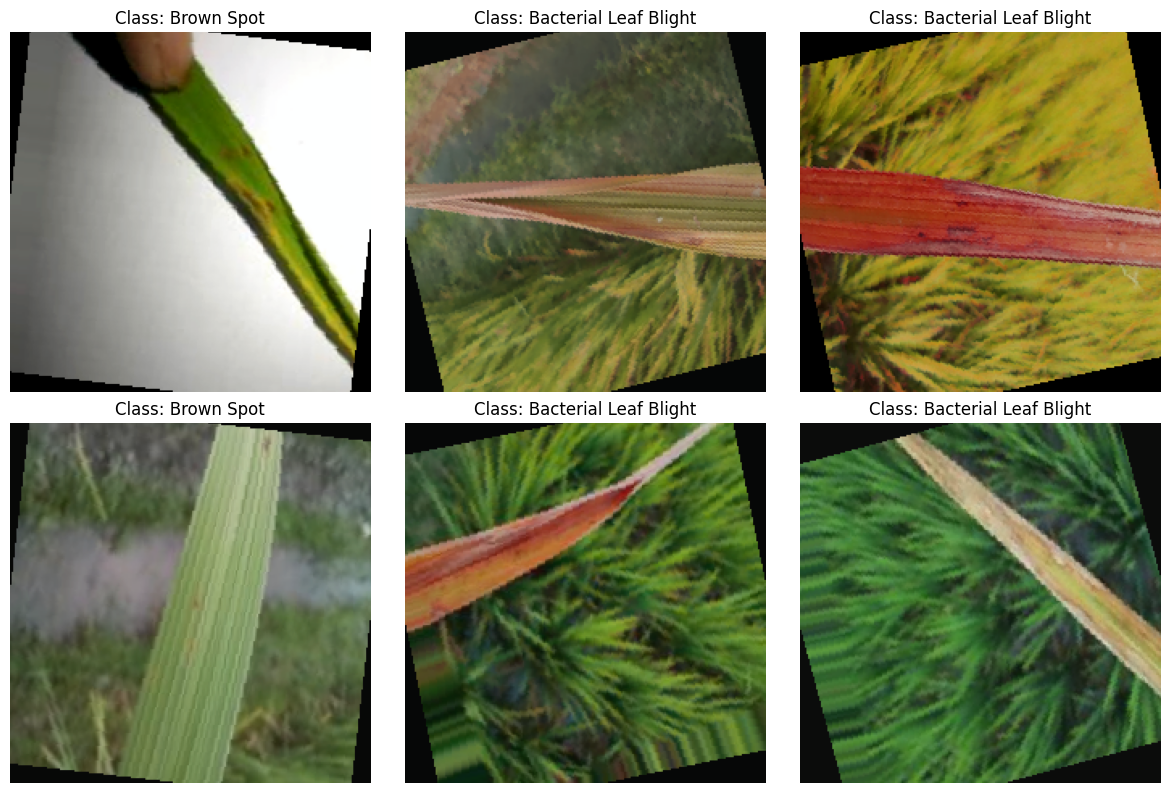

In [ ]:
# Cell 8: Visualize Sample Images
# ============================================
def show_sample_images(dataset, num_samples=6):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        img, label = dataset[i]

        # Denormalize image for display
        img = img.numpy().transpose(1, 2, 0)
        img = img * np.array(std) + np.array(mean)
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f'Class: {dataset.idx_to_class[label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(train_dataset)

In [ ]:
# Cell 9: Define ResNet-18 Model
# ============================================
class RiceDiseaseResNet18(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(RiceDiseaseResNet18, self).__init__()

        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=pretrained)

        # Freeze early layers (optional - uncomment to freeze)
        # for param in list(self.resnet.parameters())[:-10]:
        #     param.requires_grad = False

        # Get the number of input features for the final FC layer
        num_features = self.resnet.fc.in_features

        # Replace the final FC layer with custom classifier
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Create model
model = RiceDiseaseResNet18(num_classes=len(target_diseases), pretrained=True)
model = model.to(device)

# Print model summary
print("Model Architecture:")
print("="*50)
summary(model, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-1

In [ ]:
# Cell 10: Define Training Functions
# ============================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss/len(progress_bar),
            'acc': 100.*correct/total
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss/len(progress_bar),
                'acc': 100.*correct/total
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [ ]:
# Cell 11: Setup Training Parameters
# ============================================
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (removed 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Training settings
num_epochs = 25
best_val_acc = 0.0
best_model_path = 'best_rice_disease_model.pth'

# History for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [ ]:
# Cell 12: Train the Model
# ============================================
print("Starting Training...")
print("="*50)

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Save history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, best_model_path)
        print(f'Best model saved with validation accuracy: {best_val_acc:.2f}%')

print("\n" + "="*50)
print("Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

Starting Training...

Epoch [1/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.11it/s, loss=0.517, acc=80.8]


Train Loss: 0.7824, Train Acc: 66.32%
Val Loss: 0.5167, Val Acc: 80.84%
Best model saved with validation accuracy: 80.84%

Epoch [2/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.11it/s, loss=0.691, acc=69.3]


Train Loss: 0.6080, Train Acc: 75.30%
Val Loss: 0.6906, Val Acc: 69.34%

Epoch [3/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.10it/s, loss=0.755, acc=74.2]


Train Loss: 0.5682, Train Acc: 75.75%
Val Loss: 0.7554, Val Acc: 74.22%

Epoch [4/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.10it/s, loss=1.01, acc=56.8]


Train Loss: 0.4919, Train Acc: 80.69%
Val Loss: 1.0069, Val Acc: 56.79%

Epoch [5/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s, loss=0.422, acc=82.9]


Train Loss: 0.5384, Train Acc: 77.69%
Val Loss: 0.4219, Val Acc: 82.93%
Best model saved with validation accuracy: 82.93%

Epoch [6/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.05it/s, loss=0.476, acc=79.4]


Train Loss: 0.4673, Train Acc: 81.66%
Val Loss: 0.4758, Val Acc: 79.44%

Epoch [7/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.14it/s, loss=0.323, acc=87.8]


Train Loss: 0.4320, Train Acc: 82.93%
Val Loss: 0.3228, Val Acc: 87.80%
Best model saved with validation accuracy: 87.80%

Epoch [8/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.08it/s, loss=0.221, acc=91.3]


Train Loss: 0.3817, Train Acc: 84.13%
Val Loss: 0.2208, Val Acc: 91.29%
Best model saved with validation accuracy: 91.29%

Epoch [9/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.00it/s, loss=0.261, acc=87.8]


Train Loss: 0.3900, Train Acc: 83.91%
Val Loss: 0.2612, Val Acc: 87.80%

Epoch [10/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.08it/s, loss=0.195, acc=91.6]


Train Loss: 0.3370, Train Acc: 87.50%
Val Loss: 0.1952, Val Acc: 91.64%
Best model saved with validation accuracy: 91.64%

Epoch [11/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s, loss=0.237, acc=90.9]


Train Loss: 0.3286, Train Acc: 87.28%
Val Loss: 0.2366, Val Acc: 90.94%

Epoch [12/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=0.164, acc=94.1]


Train Loss: 0.3322, Train Acc: 87.95%
Val Loss: 0.1645, Val Acc: 94.08%
Best model saved with validation accuracy: 94.08%

Epoch [13/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.11it/s, loss=0.403, acc=87.5]


Train Loss: 0.2827, Train Acc: 89.67%
Val Loss: 0.4026, Val Acc: 87.46%

Epoch [14/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s, loss=0.378, acc=81.5]


Train Loss: 0.3299, Train Acc: 87.72%
Val Loss: 0.3778, Val Acc: 81.53%

Epoch [15/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.02it/s, loss=0.176, acc=92.7]


Train Loss: 0.2587, Train Acc: 91.02%
Val Loss: 0.1764, Val Acc: 92.68%

Epoch [16/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s, loss=0.351, acc=88.9]


Train Loss: 0.2605, Train Acc: 90.27%
Val Loss: 0.3515, Val Acc: 88.85%

Epoch [17/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.00it/s, loss=0.134, acc=95.1]


Train Loss: 0.2255, Train Acc: 92.29%
Val Loss: 0.1343, Val Acc: 95.12%
Best model saved with validation accuracy: 95.12%

Epoch [18/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.04it/s, loss=0.0854, acc=96.5]


Train Loss: 0.1499, Train Acc: 94.39%
Val Loss: 0.0854, Val Acc: 96.52%
Best model saved with validation accuracy: 96.52%

Epoch [19/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s, loss=0.0902, acc=96.2]


Train Loss: 0.1724, Train Acc: 94.16%
Val Loss: 0.0902, Val Acc: 96.17%

Epoch [20/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s, loss=0.108, acc=96.5]


Train Loss: 0.1621, Train Acc: 94.46%
Val Loss: 0.1082, Val Acc: 96.52%

Epoch [21/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.13it/s, loss=0.133, acc=95.8]


Train Loss: 0.1149, Train Acc: 96.11%
Val Loss: 0.1326, Val Acc: 95.82%

Epoch [22/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s, loss=0.0987, acc=96.9]


Train Loss: 0.1324, Train Acc: 94.91%
Val Loss: 0.0987, Val Acc: 96.86%
Best model saved with validation accuracy: 96.86%

Epoch [23/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s, loss=0.0356, acc=99]


Train Loss: 0.1136, Train Acc: 95.43%
Val Loss: 0.0356, Val Acc: 98.95%
Best model saved with validation accuracy: 98.95%

Epoch [24/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s, loss=0.0355, acc=99]


Train Loss: 0.0985, Train Acc: 96.63%
Val Loss: 0.0355, Val Acc: 98.95%

Epoch [25/25]


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.03it/s, loss=0.0395, acc=98.3]

Train Loss: 0.0986, Train Acc: 96.56%
Val Loss: 0.0395, Val Acc: 98.26%

Training Complete!
Best Validation Accuracy: 98.95%


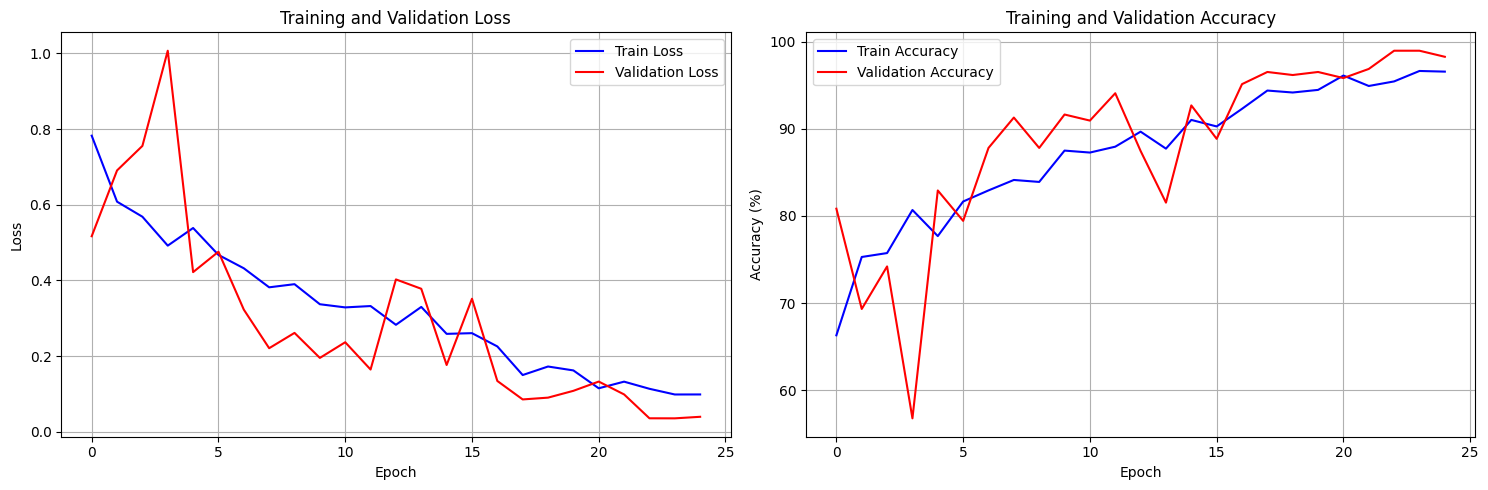

In [ ]:
# Cell 13: Plot Training History
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accs, label='Train Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 14: Evaluate on Test Set
# ============================================
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

print("Evaluating on Test Set...")
print("="*50)

# Test the model
test_loss, test_acc, test_predictions, test_labels = validate_epoch(
    model, test_loader, criterion, device
)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

Evaluating on Test Set...


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.03it/s, loss=0.0728, acc=97.9]

Test Loss: 0.0728
Test Accuracy: 97.91%


In [ ]:
# Cell 15: Generate Classification Report
# ============================================
# Get class names
class_names = target_diseases

# Generate classification report
print("\nClassification Report:")
print("="*50)
report = classification_report(
    test_labels, test_predictions,
    target_names=class_names,
    digits=4
)
print(report)


Classification Report:
                       precision    recall  f1-score   support

           Brown Spot     1.0000    0.9691    0.9843        97
Bacterial Leaf Blight     0.9895    0.9792    0.9843        96
           Leaf scald     0.9490    0.9894    0.9688        94

             accuracy                         0.9791       287
            macro avg     0.9795    0.9792    0.9791       287
         weighted avg     0.9798    0.9791    0.9792       287



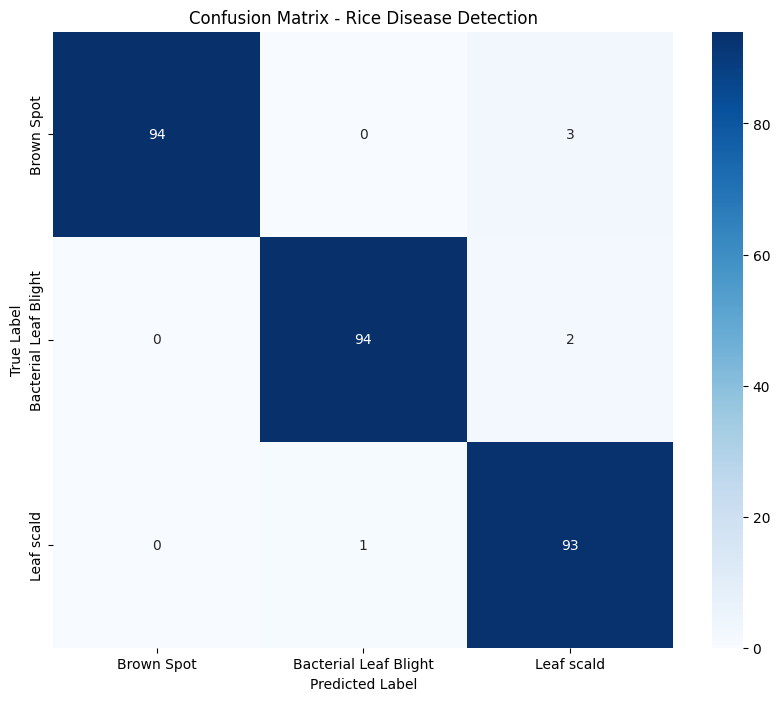


Per-Class Accuracy:
Brown Spot: 96.91%
Bacterial Leaf Blight: 97.92%
Leaf scald: 98.94%


In [ ]:
# Cell 16: Plot Confusion Matrix
# ============================================
def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - Rice Disease Detection')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate per-class accuracy
    print("\nPer-Class Accuracy:")
    print("="*50)
    for i, class_name in enumerate(classes):
        if cm[i].sum() > 0:
            class_acc = cm[i, i] / cm[i].sum() * 100
            print(f"{class_name}: {class_acc:.2f}%")

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_predictions, class_names)

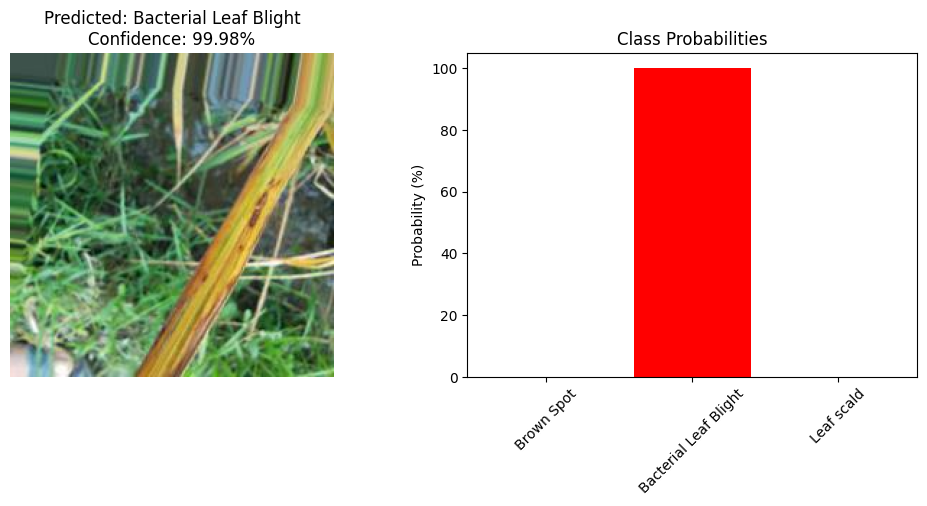

Sample Prediction: Bacterial Leaf Blight (Confidence: 99.98%)


In [ ]:
# Cell 17: Test on Single Image (Inference)
# ============================================
def predict_single_image(model, image_path, transform, class_names, device):
    """Predict disease for a single image"""
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence_score:.2f}%')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    probs = probabilities.squeeze().cpu().numpy() * 100
    colors = ['red' if i == predicted.item() else 'blue' for i in range(len(class_names))]
    plt.bar(class_names, probs, color=colors)
    plt.title('Class Probabilities')
    plt.ylabel('Probability (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return predicted_class, confidence_score

# Test on a sample image from test set
sample_image_path = X_test[0]  # Using X_test instead of test_dataset.images
predicted_class, confidence = predict_single_image(
    model, sample_image_path, test_transform, target_diseases, device
)

print(f"Sample Prediction: {predicted_class} (Confidence: {confidence:.2f}%)")

In [ ]:
# Cell 18: Model Analysis and Statistics
# ============================================
def count_parameters(model):
    """Count trainable and total parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)

print("\nModel Statistics:")
print("="*50)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: {total_params * 4 / (1024**2):.2f} MB (assuming float32)")

# Measure inference time
model.eval()
input_sample = torch.randn(1, 3, 224, 224).to(device)

# Warm up
for _ in range(10):
    _ = model(input_sample)

# Measure
import time
times = []
with torch.no_grad():
    for _ in range(100):
        start = time.time()
        _ = model(input_sample)
        times.append(time.time() - start)

avg_inference_time = np.mean(times) * 1000  # Convert to ms
print(f"Average Inference Time: {avg_inference_time:.2f} ms per image")


Model Statistics:
Total Parameters: 11,308,611
Trainable Parameters: 11,308,611
Model Size: 43.14 MB (assuming float32)
Average Inference Time: 2.62 ms per image
